In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from prophet import Prophet

import matplotlib.pyplot as plt

C:\Users\adam\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# load data
final_data = pd.read_csv("Final_Data_hourly.csv")
final_data.index = pd.to_datetime(final_data['DateTime'])
final_data = final_data.drop(columns='DateTime')

In [3]:
final_data.shape

(26210, 93)

In [4]:
# create missing datetime values
final_data = final_data.reindex(pd.date_range(start=final_data.index[0], end=final_data.index[-1], freq='1H'))

In [5]:
final_data.index

DatetimeIndex(['2016-07-07 01:00:00', '2016-07-07 02:00:00',
               '2016-07-07 03:00:00', '2016-07-07 04:00:00',
               '2016-07-07 05:00:00', '2016-07-07 06:00:00',
               '2016-07-07 07:00:00', '2016-07-07 08:00:00',
               '2016-07-07 09:00:00', '2016-07-07 10:00:00',
               ...
               '2019-07-07 14:00:00', '2019-07-07 15:00:00',
               '2019-07-07 16:00:00', '2019-07-07 17:00:00',
               '2019-07-07 18:00:00', '2019-07-07 19:00:00',
               '2019-07-07 20:00:00', '2019-07-07 21:00:00',
               '2019-07-07 22:00:00', '2019-07-07 23:00:00'],
              dtype='datetime64[ns]', length=26303, freq='H')

In [6]:
# need to slice off 23 data points to make the set equal to full days worth of data. may or may not be required
len(final_data.iloc[23:,:]) / 24

1095.0

In [7]:
# fill 0 values with nan
final_data = final_data.replace(0, np.nan)

# fill the huge outliers w/ nan
final_data = final_data.replace(42529.29, np.nan)
final_data = final_data.replace(2066.410253409038, np.nan)

In [8]:
# fill msising values with the previous 24 hr reading
final_data['south_total_flow'] = final_data['south_total_flow'].fillna(final_data['south_total_flow'].shift(24))
final_data['north_total_flow'] = final_data['north_total_flow'].fillna(final_data['north_total_flow'].shift(24))
final_data['south_total_power_usage'] = final_data['south_total_power_usage'].fillna(final_data['south_total_power_usage'].shift(24))
final_data['north_total_power_usage'] = final_data['north_total_power_usage'].fillna(final_data['north_total_power_usage'].shift(24))

# there will still be nans to use the mean of the previous and next data point
final_data['south_total_flow'] = final_data['south_total_flow'].fillna((final_data['south_total_flow'].ffill()+final_data['south_total_flow'].bfill())/2)
final_data['north_total_flow'] = final_data['north_total_flow'].fillna((final_data['north_total_flow'].ffill()+final_data['north_total_flow'].bfill())/2)
final_data['south_total_power_usage'] = final_data['south_total_power_usage'].fillna((final_data['south_total_power_usage'].ffill()+final_data['south_total_power_usage'].bfill())/2)
final_data['north_total_power_usage'] = final_data['north_total_power_usage'].fillna((final_data['north_total_power_usage'].ffill()+final_data['north_total_power_usage'].bfill())/2)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

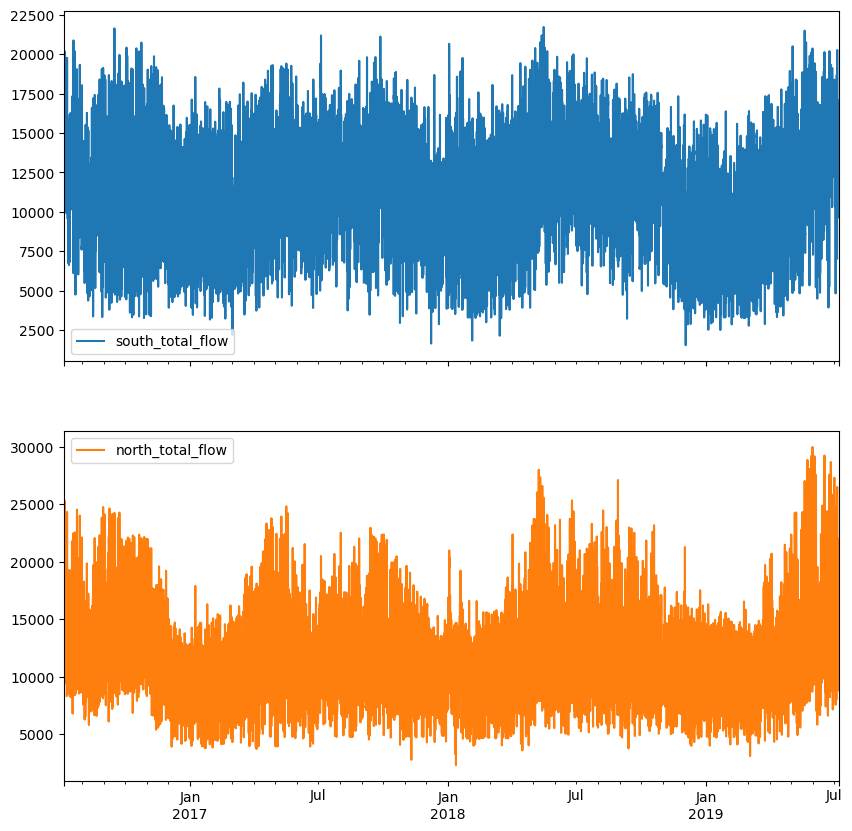

In [9]:
final_data[['south_total_flow', 'north_total_flow']].plot(figsize=(10,10), subplots=True)

In [10]:
final_data.to_csv('Final_Data_hourly_clean.csv', index=True)

In [13]:
from datetime import timedelta
#from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import pandas as pd

class forecast:
    def __init__(self, hist):
        """
        Class containing forecasting methods
        :param hist: cleaned Final_Data_hourly.csv
        """
        self.hist = hist
    def train_test(self, train_pct):
        """
        function to return training and testing df's
        
        :param train_pct: percentage of data to use as training
        """
        train_idx = int(len(self.hist) * train_pct)
        
        # slice on all previous data to train on
        train = self.hist.iloc[:train_idx,:]
        
        # create a df for the forecast period
        test = self.hist.iloc[train_idx:,:]
        
        return train, test
        
    def ets(self, start:str, end:str):
        """
        Naive forecast based on multiple seasonal treand decomposition based on LOESS
 
        :param start: string in format of '2016-01-01 01:00:00'
        :param end: string in format of '2016-01-02 17:00:00'
        """
        assert (pd.to_datetime(start) - timedelta(days=365)) > self.hist.index[0], f"Not enough historical data, >= 1 year is needed"
        
        # slice on all previous data to train on
        train = self.hist.loc[:pd.to_datetime(start)-timedelta(hours=1)]

        # fit models for north and south region
        # ETS
        north_model = ETSModel(
            train['north_total_flow'],
            error="add",
            trend="add",
            seasonal="add",
            damped_trend=False,
            seasonal_periods=24,
        )
        north_fit = north_model.fit(disp=0)

        south_model = ETSModel(
            train['south_total_flow'],
            error="add",
            trend="add",
            seasonal="add",
            damped_trend=False,
            seasonal_periods=24,
        )
        south_fit = south_model.fit(disp=0)
        
        # create a df for the forecast period
        predict = self.hist.loc[start:end].copy()
        north_predict = north_fit.predict(start=start, end=end)
        south_predict = south_fit.predict(start=start, end=end)
        
        
        predict['north_pred'] = north_predict
        predict['south_pred'] = south_predict
        return predict[['north_total_flow', 'south_total_flow', 'north_pred', 'south_pred']]
        #return pred

In [14]:
m = forecast(final_data)

In [15]:
train, test = m.train_test(0.8)

In [16]:
train.shape

(21042, 93)

In [18]:
test.shape

(5261, 93)

# testing Prophet

In [210]:
m = Prophet()
m_s = Prophet()

In [213]:
north_train = pd.DataFrame(train['north_total_flow']).copy()
south_train = pd.DataFrame(train['south_total_flow']).copy()

In [214]:
north_train['ds'] = north_train.index
south_train['ds'] = south_train.index

In [215]:
north_train.columns = ['y', 'ds']
south_train.columns = ['y', 'ds']

In [216]:
north_train = north_train[['ds', 'y']]
south_train = south_train[['ds', 'y']]

In [217]:
m.fit(north_train)
m_s.fit(south_train)

23:41:02 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing
23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing


In [218]:
n_future = m.make_future_dataframe(periods=5261, freq='H')
s_future = m_s.make_future_dataframe(periods=5261, freq='H')

In [221]:
n_fcst = m.predict(n_future)
s_fcst = m_s.predict(s_future)

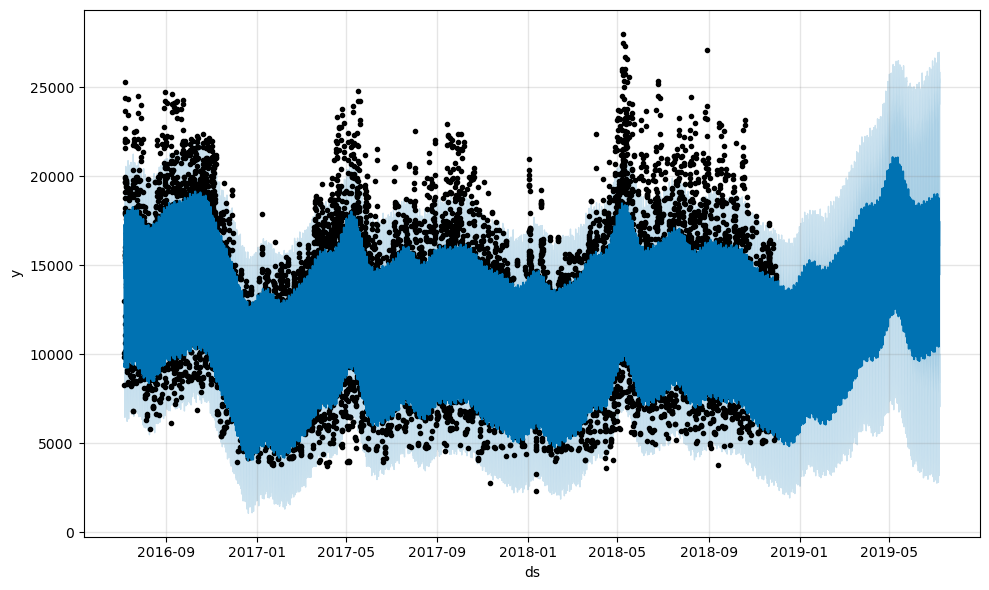

In [222]:
m.plot(n_fcst);

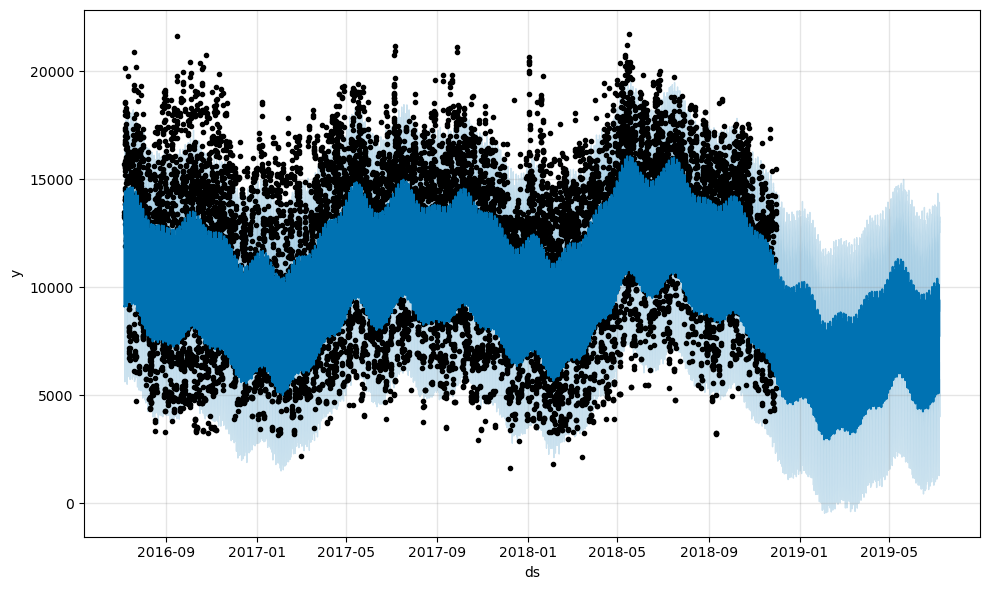

In [224]:
m_s.plot(s_fcst);

In [225]:
# in sample
print(f"North train RMSE: {np.sqrt(mean_squared_error(train['north_total_flow'], n_fcst.iloc[:len(train),:]['yhat']))}")
print(f"South train RMSE: {np.sqrt(mean_squared_error(train['south_total_flow'], s_fcst.iloc[:len(train),:]['yhat']))}")

North train RMSE: 2184.5404980110325
South train RMSE: 2631.378686321545


In [226]:
# OOS
print(f"North test RMSE: {np.sqrt(mean_squared_error(test['north_total_flow'], n_fcst.iloc[-len(test):,:]['yhat']))}")
print(f"South test RMSE: {np.sqrt(mean_squared_error(test['south_total_flow'], s_fcst.iloc[-len(test):,:]['yhat']))}")

North test RMSE: 3344.065672931223
South test RMSE: 4359.486358827224


In [227]:
north_train = n_fcst.iloc[20792:21042][['ds', 'yhat']].copy()
north_train.index = north_train['ds']
north_train = north_train.join(train.iloc[-250:,:]['north_total_flow'], how='left')

south_train = s_fcst.iloc[20792:21042][['ds', 'yhat']].copy()
south_train.index = south_train['ds']
south_train = south_train.join(train.iloc[-250:,:]['south_total_flow'], how='left')

<AxesSubplot:title={'center':'North last 250 hours of training'}, xlabel='ds'>

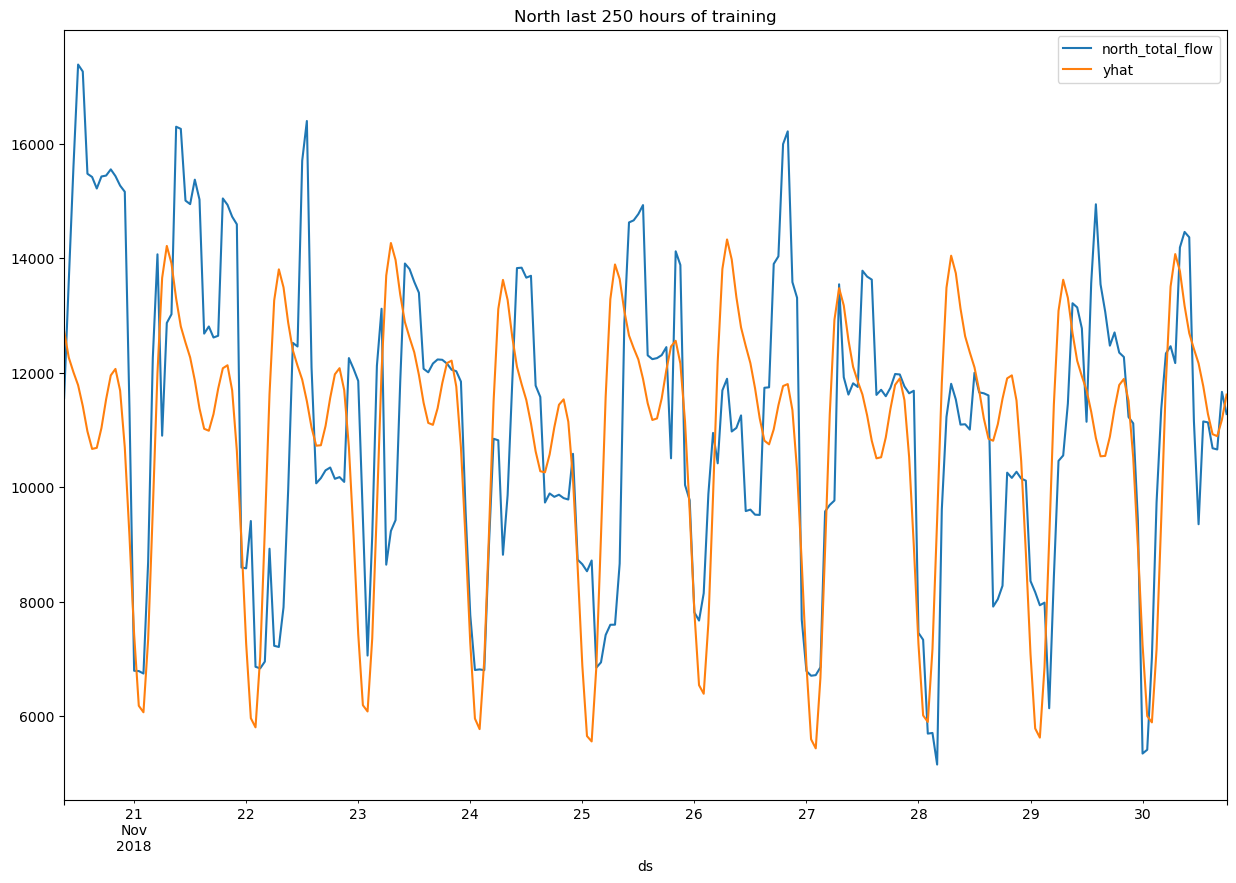

In [228]:
north_train[['north_total_flow', 'yhat']].plot(figsize=(15,10), title="North last 250 hours of training")

<AxesSubplot:title={'center':'South last 250 hours of training'}, xlabel='ds'>

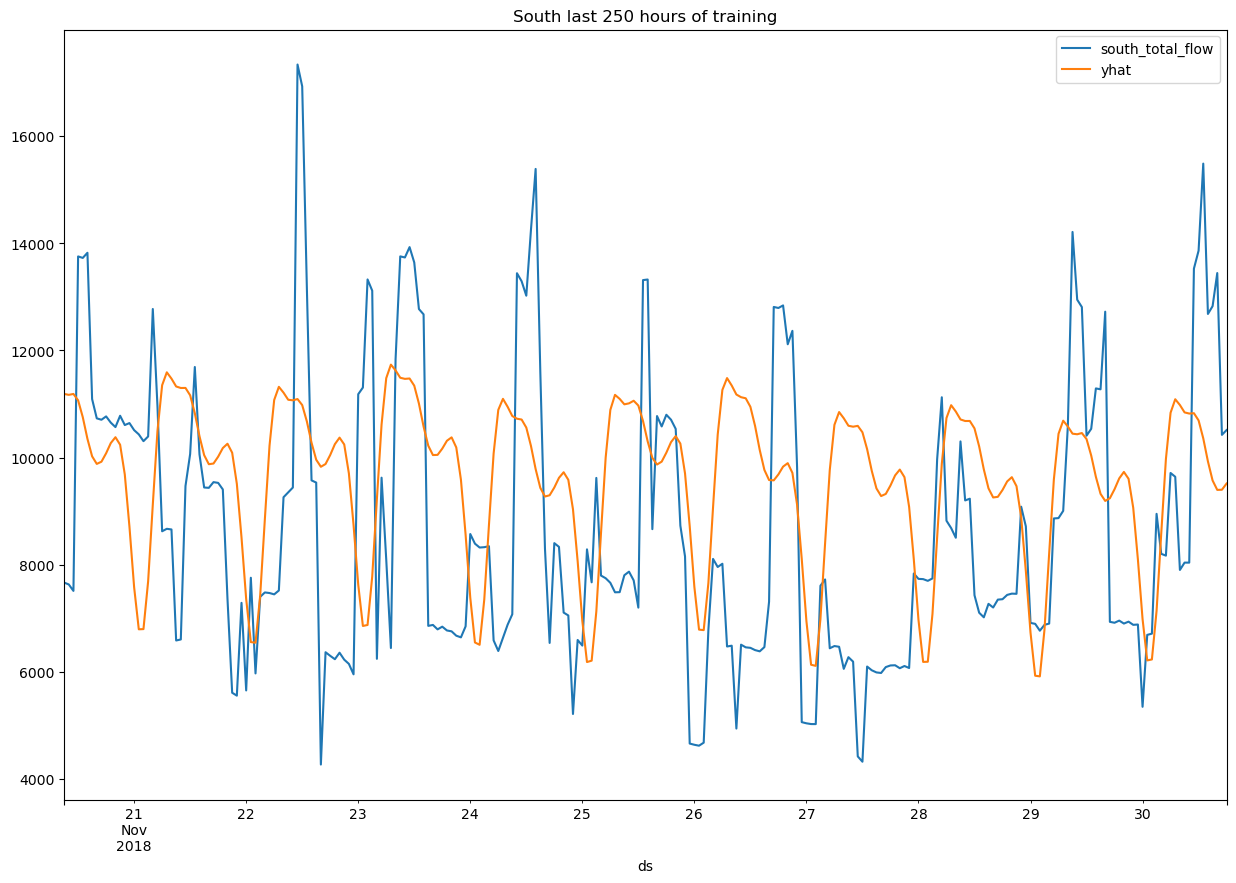

In [229]:
south_train[['south_total_flow', 'yhat']].plot(figsize=(15,10), title="South last 250 hours of training")

In [230]:
north_test = n_fcst.iloc[21042:,:][['ds', 'yhat']].copy()
north_test.index = north_test['ds']
north_test = north_test.join(test['north_total_flow'], how='left')

south_test = s_fcst.iloc[21042:,:][['ds', 'yhat']].copy()
south_test.index = south_test['ds']
south_test = south_test.join(test['south_total_flow'], how='left')

<AxesSubplot:title={'center':'North first 250 hours of OOS test'}, xlabel='ds'>

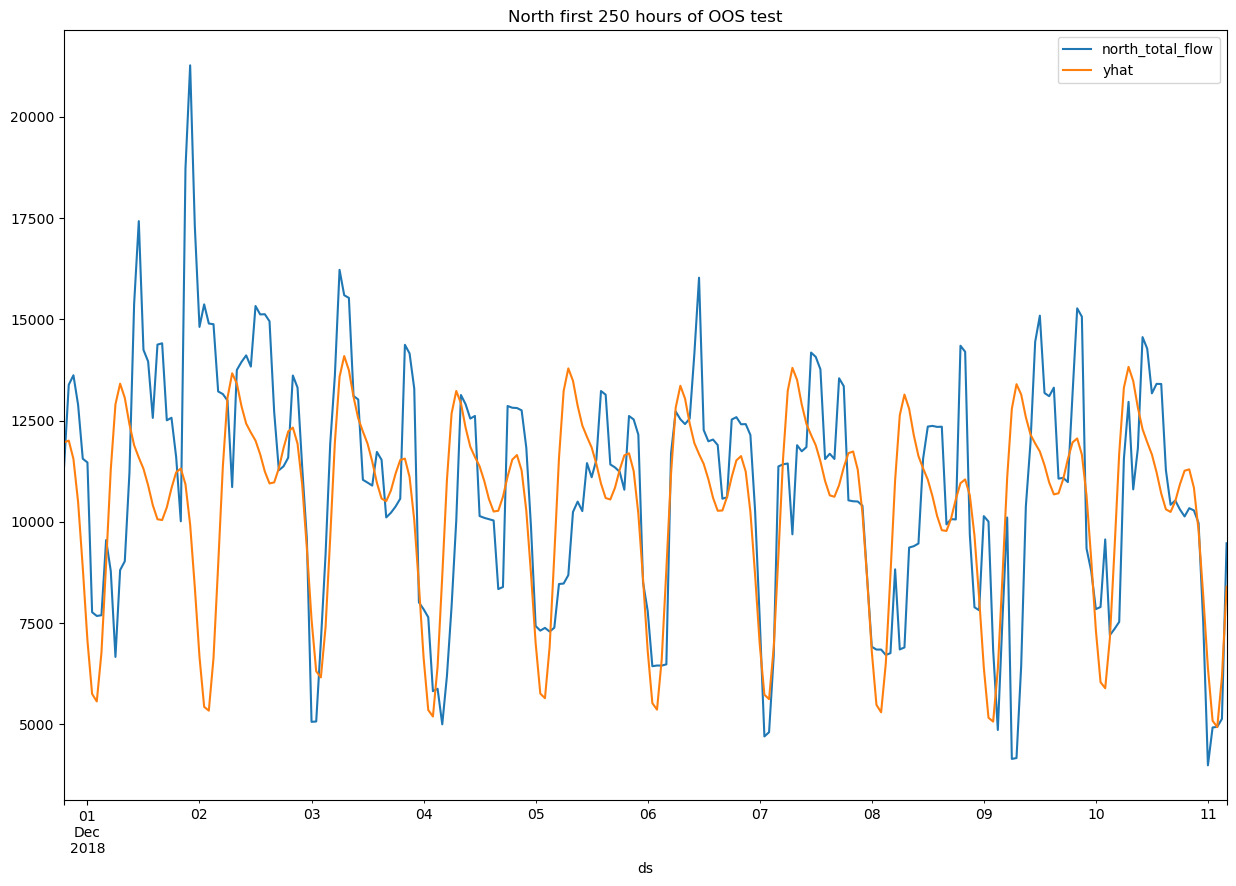

In [231]:
north_test.iloc[:250,:][['north_total_flow', 'yhat']].plot(figsize=(15,10), title='North first 250 hours of OOS test')

<AxesSubplot:title={'center':'South first 250 hours of OOS test'}, xlabel='ds'>

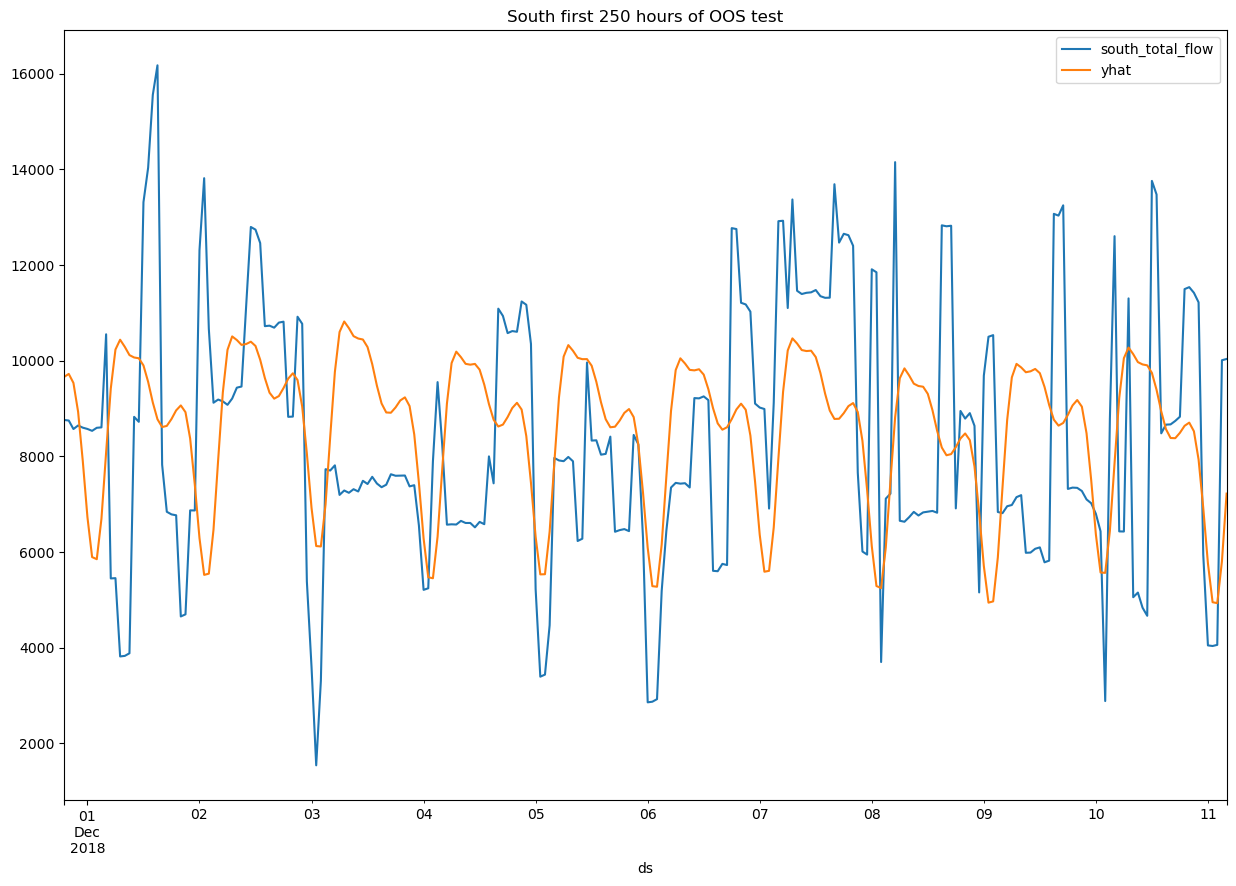

In [232]:
south_test.iloc[:250,:][['south_total_flow', 'yhat']].plot(figsize=(15,10), title='South first 250 hours of OOS test')

In [209]:
len(test)

5261

In [171]:
north_train.shape

(250, 2)

In [172]:
north_train = north_train.join(train.iloc[-250:,:]['north_total_flow'], how='left')

<AxesSubplot:title={'center':'last 250 hours of training'}, xlabel='ds'>

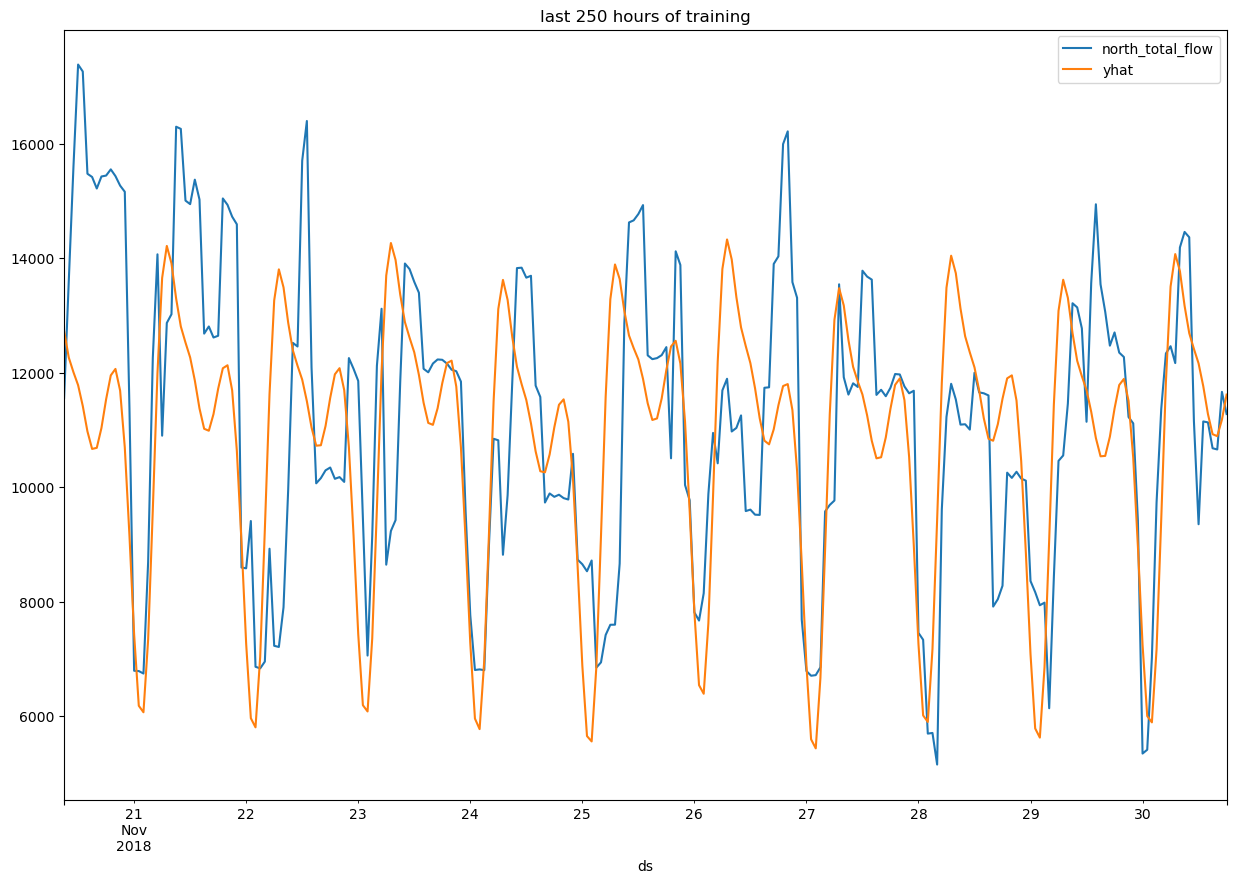

In [233]:
north_train[['north_total_flow', 'yhat']].plot(figsize=(15,10), title="last 250 hours of training")

In [234]:
(north_test['yhat'] + south_test['yhat'])

ds
2018-11-30 19:00:00    21628.313414
2018-11-30 20:00:00    21733.581122
2018-11-30 21:00:00    21093.262983
2018-11-30 22:00:00    19423.886761
2018-11-30 23:00:00    16778.930938
                           ...     
2019-07-07 19:00:00    26674.391495
2019-07-07 20:00:00    26895.160020
2019-07-07 21:00:00    26366.498663
2019-07-07 22:00:00    24803.962804
2019-07-07 23:00:00    22260.099990
Name: yhat, Length: 5261, dtype: float64

In [235]:
test.columns

Index(['PMP_1_FLOW', 'PMP_10_FLOW', 'PMP_11_FLOW', 'PMP_12_FLOW',
       'PMP_13_FLOW', 'PMP_14_FLOW', 'PMP_15_FLOW', 'PMP_16_FLOW',
       'PMP_18_FLOW', 'PMP_19_FLOW', 'PMP_2_FLOW', 'PMP_21_FLOW',
       'PMP_22_FLOW', 'PMP_23_FLOW', 'PMP_24_FLOW', 'PMP_25_FLOW',
       'PMP_27_FLOW', 'PMP_28_FLOW', 'PMP_29_FLOW', 'PMP_3_FLOW',
       'PMP_30_FLOW', 'PMP_31_FLOW', 'PMP_32_FLOW', 'PMP_4_FLOW', 'PMP_6_FLOW',
       'PMP_7_FLOW', 'PMP_8_FLOW', 'PMP_9_FLOW', 'PMP_1_PRESS', 'PMP_10_PRESS',
       'PMP_11_PRESS', 'PMP_12_PRESS', 'PMP_13_PRESS', 'PMP_14_PRESS',
       'PMP_15_PRESS', 'PMP_16_PRESS', 'PMP_18_PRESS', 'PMP_19_PRESS',
       'PMP_2_PRESS', 'PMP_21_PRESS', 'PMP_22_PRESS', 'PMP_23_PRESS',
       'PMP_24_PRESS', 'PMP_25_PRESS', 'PMP_27_PRESS', 'PMP_28_PRESS',
       'PMP_29_PRESS', 'PMP_3_PRESS', 'PMP_30_PRESS', 'PMP_31_PRESS',
       'PMP_32_PRESS', 'PMP_4_PRESS', 'PMP_6_PRESS', 'PMP_7_PRESS',
       'PMP_8_PRESS', 'PMP_9_PRESS', 'PMP_6_PowerUsage(kW-H)',
       'PMP_1_PowerUsage

In [237]:
test['total_flow'] = test['south_total_flow'] + test['north_total_flow']

C:\Users\adam\AppData\Local\Temp\ipykernel_18892\3078650723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['total_flow'] = test['south_total_flow'] + test['north_total_flow']


In [239]:
test['total_pred'] = (north_test['yhat'] + south_test['yhat'])

C:\Users\adam\AppData\Local\Temp\ipykernel_18892\86605383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['total_pred'] = (north_test['yhat'] + south_test['yhat'])


<AxesSubplot:title={'center':'OOS actual total flow vs predicted 250 hrs'}>

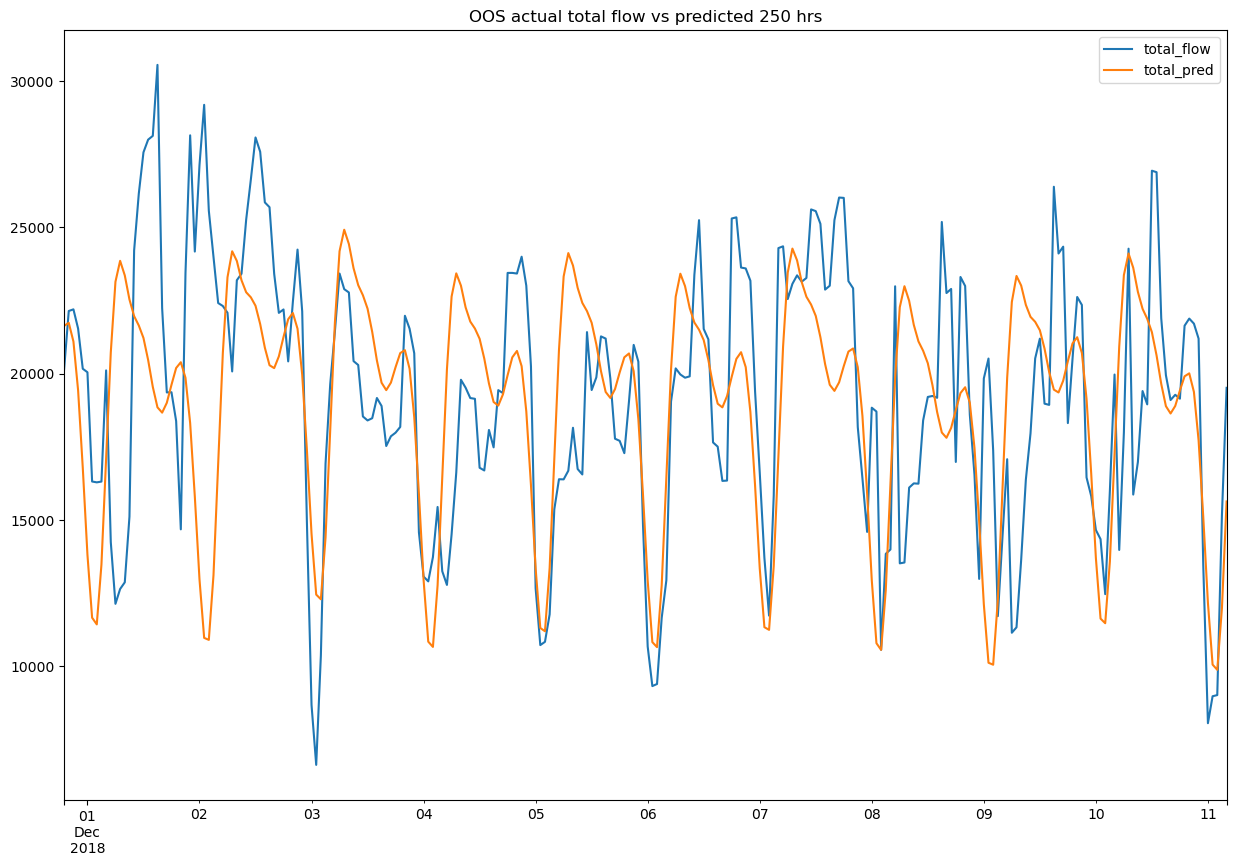

In [245]:
test.iloc[:250,:][['total_flow', 'total_pred']].plot(figsize=(15,10), title='OOS actual total flow vs predicted 250 hrs')

In [246]:
np.sqrt(mean_squared_error(test['total_flow'], test['total_pred']))

5337.341577553203

In [247]:
len(test)

5261

In [44]:
pred = m.ets(start='2019-07-01 00:00:00', end='2019-07-02 00:00:00')